## EffecientNet Finetuned Model

- 모델 앞단에는 Efficient pretrained model을 사용(Imagenet Based)
- 뒷단에 Fully Connected Layer (NN) 연결
- Effnet 뒷부분과 추가연결된 FC Layer만 Finetuning 진행.
- 성능 매우 좋지 않았음. 너무 필요없는 정보가 많은 것으로 보여짐
- MSE 640

In [1]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [3]:
len(os.listdir('data/test_img')) # 1000

127

In [4]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop

In [5]:
Thickness.reset_index(drop=True, inplace=True)
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


In [6]:
img_path_list = []

for i in range(1, 33):
    for j in range(1, 5):
        if i == 9 and j == 1: 
            continue
        img_path_list.append('./data/test_img/AI-{}_0{}_transformed.jpg'.format(i, j))
        
img_path_list[:5]


['./data/test_img/AI-1_01_transformed.jpg',
 './data/test_img/AI-1_02_transformed.jpg',
 './data/test_img/AI-1_03_transformed.jpg',
 './data/test_img/AI-1_04_transformed.jpg',
 './data/test_img/AI-2_01_transformed.jpg']

In [7]:
class dataset(Dataset):
    def __init__(self, img_path, thickness, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.thickness = thickness
        
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path[idx])
        img = np.array(img)
        if self.transform:
            img = self.transform(img)
        y = self.thickness[idx]
        return img, y

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

In [9]:
seed = 20
train, test = train_test_split(img_path_list, test_size=0.2, random_state=seed)

train_dataset = dataset(train, Thickness['Thickness'], transform)
test_dataset = dataset(test, Thickness['Thickness'], transform)

In [10]:
print(len(train_dataset), len(test_dataset))

101 26


In [11]:
efficientnet = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b0', pretrained=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.efficientnet = efficientnet
        self.fc1 = nn.Linear(1000, 1)
        
        for param in self.efficientnet.parameters():
            if param.dim() == 4:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
    def forward(self, x):
        x = self.efficientnet(x)
        x = self.fc1(x)
        return x
    
model = Net()


Using cache found in C:\Users\se99a/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Net(
  (efficientnet): GenEfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [13]:
def train(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.float().to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return model
            
def test(model, test_loader):
    model.eval()
    test_loss = 0
    output_list  = []
    thickness_list = []
    with torch.no_grad():
        for data, target in test_loader:
            thickness_list.append(target)
            data = data.to(device)
            target = target.float().to(device)
            output = model(data)
            test_loss += criterion(output, target.unsqueeze(1)).item()
            output_list.append(output)
    test_loss /= len(test_loader.dataset)
    return test_loss, output_list, thickness_list


In [14]:
epochs = 30
model = train(model, train_loader, optimizer, epochs)

c:\Users\se99a\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Epoch: 0 [0/101 (0%)]	Loss: 7094.571289
Train Epoch: 1 [0/101 (0%)]	Loss: 5582.678223
Train Epoch: 2 [0/101 (0%)]	Loss: 5260.939453
Train Epoch: 3 [0/101 (0%)]	Loss: 3880.814209
Train Epoch: 4 [0/101 (0%)]	Loss: 3739.570557
Train Epoch: 5 [0/101 (0%)]	Loss: 4374.734375
Train Epoch: 6 [0/101 (0%)]	Loss: 3186.885010
Train Epoch: 7 [0/101 (0%)]	Loss: 2295.227783
Train Epoch: 8 [0/101 (0%)]	Loss: 2216.623047
Train Epoch: 9 [0/101 (0%)]	Loss: 1583.897217
Train Epoch: 10 [0/101 (0%)]	Loss: 1023.884155
Train Epoch: 11 [0/101 (0%)]	Loss: 1196.077148
Train Epoch: 12 [0/101 (0%)]	Loss: 651.279541
Train Epoch: 13 [0/101 (0%)]	Loss: 605.916992
Train Epoch: 14 [0/101 (0%)]	Loss: 670.305237
Train Epoch: 15 [0/101 (0%)]	Loss: 260.035675
Train Epoch: 16 [0/101 (0%)]	Loss: 188.294678
Train Epoch: 17 [0/101 (0%)]	Loss: 258.544861
Train Epoch: 18 [0/101 (0%)]	Loss: 146.365356
Train Epoch: 19 [0/101 (0%)]	Loss: 221.060272
Train Epoch: 20 [0/101 (0%)]	Loss: 18.536547
Train Epoch: 21 [0/101 (0%)]	Loss

In [15]:
test_loss, output_list, thickness_list = test(model, test_loader)

In [16]:
test_loss

24.62700711763822

In [17]:
output = np.array(output_list[0])
thickness = np.array(thickness_list[0])

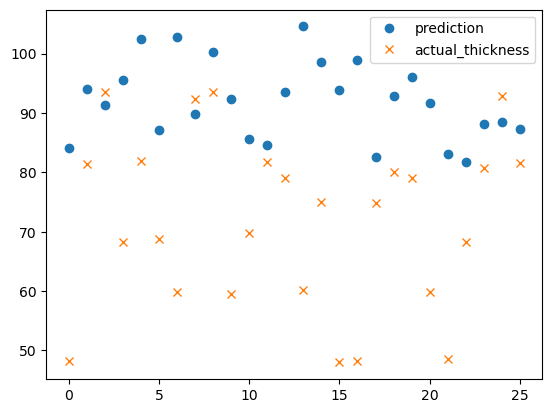

In [18]:
plt.plot(output, 'o')
plt.plot(thickness, 'x')
plt.legend(['prediction', 'actual_thickness'])
plt.show()

In [19]:
pd.DataFrame({'prediction': output.reshape(-1), 'thickness': thickness.reshape(-1)})

,prediction,thickness
0,84.175697,48.166667
1,94.086914,81.466667
2,91.280045,93.500000
3,95.633202,68.266667
4,102.485489,81.833333
5,87.106194,68.833333
6,102.748230,59.766667
7,89.790176,92.400000
8,100.198845,93.533333
9,92.428589,59.533333


In [6]:
df = pd.read_csv("./data/1st_pred_real.csv")
# MSE
print("MSE::")
np.mean((df['prediction'] - df['thickness'])**2)

MSE::


640.3021871322825